In [1]:
import numpy as np
import pickle

from classes.agent import Agent
from classes.ou_network import OU_Network
from classes.internal_state import Normative_DIS, Local_computations_omniscient_DIS, Local_computations_interfocus_DIS
from classes.action_state import Discounted_gain_soft_horizon_TSAS, Undiscounted_gain_hard_horizon_TSAS
from classes.sensory_state import Omniscient_ST

from classes.experiment import Experiment

from methods.policies import softmax_policy_init
from methods.empirical_priors import discrete_empirical_priors


In [2]:
## Import behavioural experiment
with open('/home/vbtesh/documents/CompProjects/vbtCogSci/csl2analysis/data/csl_2_modelling_data.obj', 'rb') as inFile:
    modelling_data = pickle.load(inFile)


In [3]:
part_key = '5ef109c89196fa6d5cf6c005'
conditions = ['generic', 'congruent', 'incongruent', 'implausible']
cond = conditions[0]


In [4]:
# Model fitting
fitting = True # If false, no data will be used 

## Data from trial
part_data = modelling_data[part_key]['trials'][cond]
posterior = part_data['posterior']
data = part_data['data']
inters = part_data['inters']
inters_fit = part_data['inters_fit']
judgement_data = part_data['links_hist']

In [5]:

# General model parameters (true for all trials)
if fitting:
    N = data.shape[0] - 1
    K = data.shape[1]
else:
    N = 300
    K = 3
links = np.array([-1, -0.5, 0, 0.5, 1])
theta = 0.5
dt = 0.2
sigma = 1 
# Set up priors
flat_prior = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
flat_prior = np.tile(flat_prior, (6, 1))
random_prior = np.random.rand(6, 5)
random_prior = random_prior / random_prior.sum(axis=1).reshape((6, 1))
prior_perfect = np.array([[1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 1, 0, 0],
                             [1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 1, 0, 0]])
# Emprical Priors
if 'prior' in part_data.keys():
    part_map = part_data['prior'] # Participant's maximum a priori
    empirical_priors, entropy = discrete_empirical_priors(part_map, links, temp)
else:
    empirical_priors = random_prior
temp = 3/2 # Must be explored further

## Final prior assignment
prior = empirical_priors

# Ground truth model
## Import from behavioural experiment
gt_behavioural_exp = part_data['ground_truth']
## Any model as np.ndarray
custom_model = np.array([-1, 0, .0, -1, 0, 0])
## Final ground truth assignment
true_model = custom_model
# Action parameters
## Number of model to sample from the posterior
C = 1
## Different action possibility
poss_actions = np.arange(-100, 100)
poss_actions = np.array([85, 45, 0, -45, -85])
poss_actions = np.arange(-100, 101, step=10)
## Define action length (TO BE REFINED FOR FITTING DATA)
action_len = 5 
## Policy for action selection from action values
policy_funcs = softmax_policy_init(1) # Returns three function: sample, pmf, params
## Parameters
epsilon = 1e-2 # Certainty threshold: agent stops intervening after entropy goes below epsilon
knowledge = False  # Can be a model as nd.array, True for perfect knowledge, 'random' for random sampling and False for posterior based sampling
## Special parameters for tree searches
horizon = 1e-1 # For soft horizon discounted gain
discount = 0.1 # For soft horizon discounted gain
depth = 0 # Horizon for hard horizon undiscounted gain
## General behaviour parameter
behaviour = 'random'   # Can be 'obs', 'random' or 'actor'


In [8]:
sensory_state = Omniscient_ST(N, K)
    
action_state = Discounted_gain_soft_horizon_TSAS(N, K, behaviour, poss_actions, action_len, policy_funcs, epsilon, C, knowledge, discount, horizon)
action_state = Undiscounted_gain_hard_horizon_TSAS(N, K, behaviour, poss_actions, action_len, policy_funcs, epsilon, C, knowledge, depth)

internal_state = Normative_DIS(N, K, prior, links, dt, theta, sigma, sample_params=False)
internal_state = Local_computations_omniscient_DIS(N, K, prior, links, dt, theta, sigma, sample_params=False)
#internal_state = Local_computations_interfocus_DIS(N, K, prior, links, dt, theta, sigma, sample_params=False)

external_state = OU_Network(N, K, true_model, theta, dt, sigma)
agent = Agent(N, sensory_state, internal_state, action_state)

if fitting:
    external_state.load_trial_data(data)
    action_state.load_action_data(inters, inters_fit, data)
    internal_state.load_judgement_data(judgement_data, posterior)
    
experiment = Experiment(agent, external_state)


In [9]:
# Run experiment
if fitting:
    experiment.fit(posterior)
else:
    experiment.run()

#experiment.entropy_report()

Iter: 0 Current MAP: [0.  0.  1.  1.  0.5 0. ] Current LL: -4.1588830833596715
Iter: 10 Current MAP: [ 1.   1.   0.   1.  -0.5 -1. ] Current LL: -37.42994775023704
Iter: 20 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -70.7010124171144
Iter: 30 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -112.28984325071109
Iter: 40 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -153.87867408430787
Iter: 50 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -191.30862183454502
Iter: 60 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -228.73856958478217
Iter: 70 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -257.85075116829995
Iter: 80 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -299.4395820018968


/home/vbtesh/documents/CompProjects/vbtCogSci/active_learning_agent/classes/internal_state.py:329: RuntimeWarning: divide by zero encountered in log
  log_likelihood_per_link[idx, :] = np.log(likelihood_norm)


Iter: 90 Current MAP: [1. 1. 0. 1. 0. 0.] Current LL: -341.0284128354936
Iter: 100 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -374.2994775023711
Iter: 110 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -399.2527760025292
Iter: 120 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -436.6827237527663
Iter: 130 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 140 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 150 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 160 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 170 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 180 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf


/home/vbtesh/documents/CompProjects/vbtCogSci/active_learning_agent/classes/internal_state.py:217: RuntimeWarning: divide by zero encountered in log
  log_prob = np.log(self.posterior_over_links[link_idx, value_idx])


Iter: 190 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 200 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 210 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 220 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 230 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 240 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 250 Current MAP: [ 0.5  1.   0.   1.   0.  -0.5] Current LL: -inf
Iter: 260 Current MAP: [ 0.5  1.   0.5  1.   0.5 -0.5] Current LL: -inf
Iter: 270 Current MAP: [ 0.5  1.   0.5  1.   0.5 -0.5] Current LL: -inf
Iter: 280 Current MAP: [-1. -1. -1. -1. -1. -1.] Current LL: -inf
Iter: 290 Current MAP: [-1. -1. -1. -1. -1. -1.] Current LL: -inf


/home/vbtesh/documents/CompProjects/vbtCogSci/active_learning_agent/classes/internal_state.py:234: RuntimeWarning: invalid value encountered in subtract
  LL_n = LL - np.amax(LL, axis=1).reshape(LL.shape[0], 1)


IndexError: index 301 is out of bounds for axis 0 with size 301

True model: [-1.  0.  0. -1.  0.  0.]
Final MAP: [-1.  -1.   0.  -1.   0.   0.5]


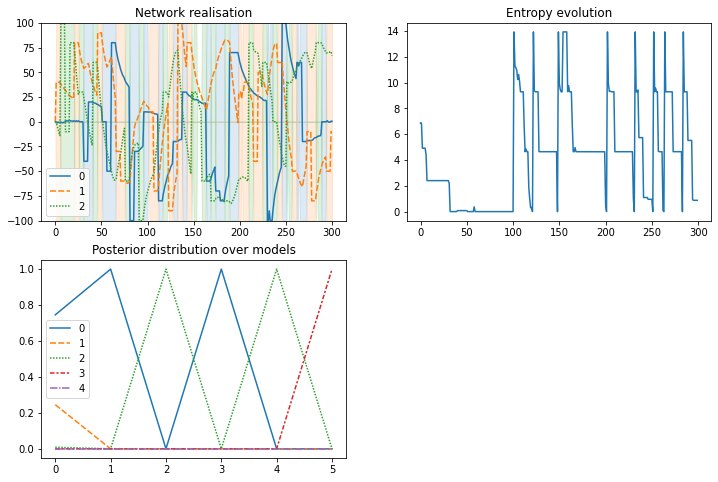

In [12]:
experiment.entropy_report()

In [19]:
LL = internal_state._posterior_params_history[150]
LL_n = LL - np.amax(LL)
lh = np.exp(LL_n) / np.exp(LL_n).sum()

print(lh)
print(LL_n)

internal_state._models_to_links(lh)

[0. 0. 0. ... 0. 0. 0.]
[-48245.87949599 -21604.54075854 -20257.3368764  ... -24768.98664172
 -18417.89534877 -41502.72154174]


array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 4.38976664e-204],
       [1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 4.38976664e-204],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 4.38976664e-204]])

# Fitting

When fitting, we have data about the external states, the interventions a participant made, i.e. action states, and their judgement or any other direct measure of their internal states. 

By definition, sensory states are never observed because they are always implicit. In many cases such as in a control environment, internal states will not be directly observed using judgement but should be inferred from actions states

The dependencies between all core modules imply that fitting a dataset of observations, actions and judgments is only valid for the current global parametrisation of the agent, i.e. the collection of internal, sensory and action states. We can compare how things change when changing one of the modules but we cannot seperate the likelihoods over the different modules.

## Where should the data be stored when fitting?

Basically the question is programming related and asks how should the data be split when initialising the states of the experiment. It could be a seperate method "load_data" called seperately from initialising the agent and the external states. Given the current way the states objects are structured, it creates an inconsistency where parameters have to be specified before hand before being overwritten.

# Questions

## Number of datapoints

The log likelihood is highly sensitive to the number of datapoints. If we assume that the participant cannot observe all datapoints for instance, we artificially reduce the log likelihood. So what can we do?

What do we do when encountering negative infinities, i.e. probability 0. Conceptually it can make sense but it is still highly dependent on the number of datapoints again as some discrete models will simply converge numerically to point masses given enough datapoints. Can we simply conclude to the extreme unlikeliness of this model?

## Number of parameters

Also the number of parameters in a model is not straightforward: in the discrete case model representation has 15625 and links representation has 30, but one is a direct function of the other without adding any additional parameters. In a continuous case, easier to represent as it is the collection of parameters of the PDF.